## Load packages

In [1]:
import sys
sys.path.append(sys.path[0] + '/bin')

In [2]:
import PyMorpionSolitaire

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pqdm.processes import pqdm
import os.path
import random

## Define game type

Define the game type:
- starting configuration ('c' for cross or 'p' for pipe)
- length of line (4 or 5)
- touching or disjoint

In [11]:
game_type = 'c'
line_length = 4
disjoint = False

In [12]:
if line_length == 4:
    if disjoint:
        Game = PyMorpionSolitaire.Game5D
    else:
        Game = PyMorpionSolitaire.Game5T
elif line_length == 3:
    if disjoint:
        Game = PyMorpionSolitaire.Game4D
    else:
        Game = PyMorpionSolitaire.Game4T
        
data_folder = 'data/'
prefix = '{}{}{}'.format('cross' if game_type == 'c' else 'pipe', line_length + 1, 'D' if disjoint else 'T')
mc_file = data_folder + prefix + '_mc.npy'
nested_file = data_folder + prefix + '_nested.npy'
nested2_file = data_folder + prefix + '_nested2.npy'
nested3_file = data_folder + prefix + '_nested3.npy'
nested4_file = data_folder + prefix + '_nested4.npy'

prefix

'cross5T'

## Figures

In [13]:
def plot_frequency(file, label):
    if os.path.isfile(file):
        score_count = np.append(np.load(file), 0)
        freq = score_count / score_count.sum()
        bins = [i + 0.5 for i in range(len(freq))]
        plt.step(bins, freq, label='{} ({:,.0f} games)'.format(label, score_count.sum()))

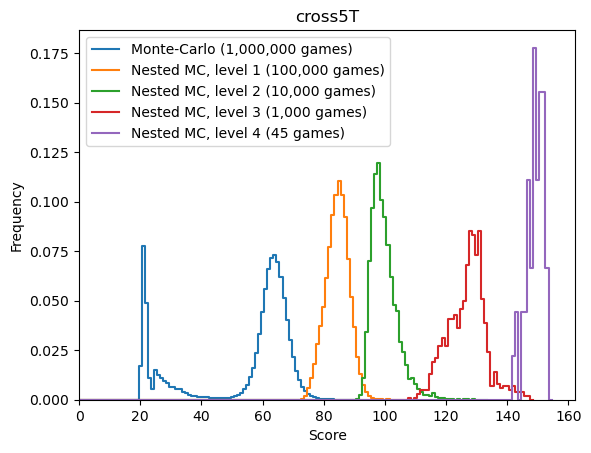

In [14]:
plot_frequency(mc_file, 'Monte-Carlo')
plot_frequency(nested_file, 'Nested MC, level 1')
plot_frequency(nested2_file, 'Nested MC, level 2')
plot_frequency(nested3_file, 'Nested MC, level 3')
plot_frequency(nested4_file, 'Nested MC, level 4')
plt.xlim(0)
plt.ylim(0)
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title(prefix)
plt.legend()
plt.savefig(data_folder + prefix + '.png')
plt.show()

## Import data from file

In [9]:
score_count = np.zeros(250).astype(int)
n = len(prefix)
for filename in os.listdir('data/nested-4-games'):
    if len(filename) == 15 + n and filename[0:n] == prefix and filename[-5:] == '.json':
        score_count[int(filename[n+1:n+4])] += 1
score_count = np.trim_zeros(score_count, 'b')
print("Number of games:", score_count.sum())
np.save(nested4_file, score_count)

Number of games: 2


## Generate data

In [16]:
def generate_data(score_fct, n, file):
    # load data from file, if existing
    if os.path.isfile(file):
        score_count = np.load(file)
        print("File", file, "has been found")
    else:
        score_count = np.array([0])
        print("File", file, "will be created")
    # resize array to allow recording higher scores
    score_count = np.concatenate((score_count, np.array([0 for _ in range(250 - score_count.size)])))
    print("Number of games before:", score_count.sum())
    # run
    for _ in tqdm(range(n)):
        score_count[score_fct()] += 1
    # shrink array before saving
    score_count = np.trim_zeros(score_count, 'b')
    print("Number of games after:", score_count.sum())
    # write data to file
    np.save(file, score_count)
    print("Result written to file", file)

In [17]:
def generate_data_parallel(score_fct, n, file, jobs):
    # load data from file, if existing
    if os.path.isfile(file):
        score_count = np.load(file)
        print("File", file, "has been found")
    else:
        score_count = np.array([0])
        print("File", file, "will be created")
    # resize array to allow recording higher scores
    score_count = np.concatenate((score_count, np.array([0 for _ in range(250 - score_count.size)])))
    print("Number of games before:", score_count.sum())
    # run
    scores = pqdm(range(n), score_fct, n_jobs=jobs)
    for score in scores:
        score_count[score] += 1
    # shrink array before saving
    score_count = np.trim_zeros(score_count, 'b')
    print("Number of games after:", score_count.sum())
    # write data to file
    np.save(file, score_count)
    print("Result written to file", file)

Play several games at random and plot the distribution of scores:

In [ ]:
game = Game(game_type)
def play_mc():
    game.restart()
    game.playAtRandom()
    return game.getScore()
generate_data(play_mc, 1000000, mc_file)

Use the nested Monte-Carlo algorithm at level 1:

In [ ]:
def play_nested(x):
    temp_game = Game(game_type)
    temp_game.playNestedMC(1)
    return temp_game.getScore()
generate_data_parallel(play_nested, 100000, nested_file, 10)

Use the nested Monte-Carlo algorithm at level 2:

In [ ]:
def play_nested2(x):
    temp_game = Game(game_type)
    temp_game.playNestedMC(2)
    return temp_game.getScore()
generate_data_parallel(play_nested2, 1000, nested2_file, 10)

Use the nested Monte-Carlo algorithm at level 3:

In [ ]:
def play_nested3(x):
    temp_game = Game(game_type)
    temp_game.playFastNestedMC(3)
    score = temp_game.getScore()
    return score
generate_data_parallel(play_nested3, 100, nested3_file, 10)